# Collision avoidance system example

This example demonstrates local stress testing of an aircraft collision avoidance system. The simulator implemented in module `SimpleACAS` describes an airspace consisting of $n$ aircraft equipped with CASs.

Each aircraft has dynamics characteristics (limiting maneuverability) and pilot response characteristics (limiting compliance with the CAS), which can be individually specified to explore different encounters. A failure is defined as an NMAC (near mid-air collision) between any two aircraft, where the parameters of an NMAC are defined in the simulation. The stochastic disturbances are the aircrafts' transition distributions, which correspond to pilot controls. AdaStress is therefore exploring the sorts of flight patterns that lead to failures.


- **System under test:** rule-based CAS active on all aircraft in airspace.
- **Failure criterion:** any two aircraft experience an NMAC. 
- **Stochastic disturbance:** three pilot controls per aircraft (vertical rate, ground acceleration, and turn rate), all behaving uncorrelated zero-mean normal distributions.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating project at `C:\Users\rlipkis\.julia\dev\adastress\examples\cas`
   Resolving package versions...
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\cas\Project.toml`
  No Changes to `C:\Users\rlipkis\.julia\dev\adastress\examples\cas\Manifest.toml`


In [2]:
include("src/SimpleACAS.jl")
using AdaStress
using ProgressMeter
using Random
using .SimpleACAS # simulation defined in module to avoid clutter

In [3]:
function mdp_env(; kwargs...)
    sim = SimpleACAS.Simulator(; n=2, seed=0, randomize=false, kwargs...)
    mdp = AdaStress.ASTMDP(sim)
    mdp.reward.event_bonus = 10000.0
    return mdp
end

mdp_env (generic function with 1 method)

## Trajectory example

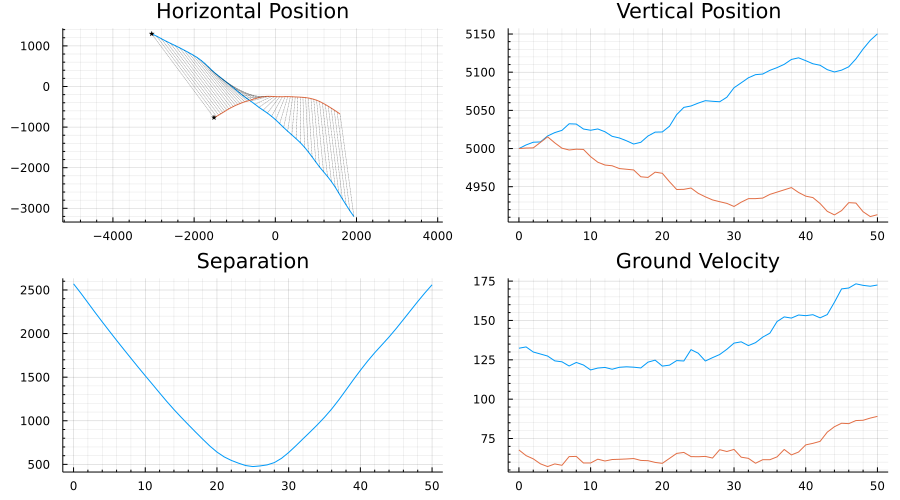

In [4]:
mdp = mdp_env(; logging=true)
Random.seed!(0)
AdaStress.Solvers.replay!(mdp, AdaStress.Solvers.RandomPolicy())
SimpleACAS.visualize(mdp.sim)

## Failure prevalence

In [5]:
Random.seed!(0)
c = 0
n_eps = 10_000

mdp = mdp_env()
@showprogress for _ in 1:n_eps
    c += AdaStress.Solvers.replay!(mdp, AdaStress.Solvers.RandomPolicy())
end
pcnt = 100 * c / n_eps
println("$c naturally-occurring failure$(c == 1 ? "" : "s") found out of $n_eps episodes ($pcnt%).")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


2 naturally-occurring failures found out of 10000 episodes (0.02%).


## MCTS

In [6]:
mcts = AdaStress.Solvers.MCTS(num_iterations=100_000)
sol = mcts(mdp_env)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12370.7
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12372.2
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12373.7
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12375.2
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12382.2
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[8.64674, -5.52582, 0.87… => 12393.9
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12396.5
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12407.3
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[-3.6445, -0.483991, -0.… => 12415.6
  MCTSResult(Dict{Symbol, Any}[Dict(:cmd_1=>[3.32626, -4.53711, -0.7… => 12422.9

## Top solutions

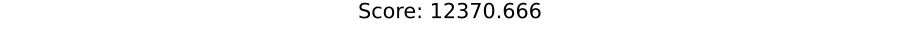

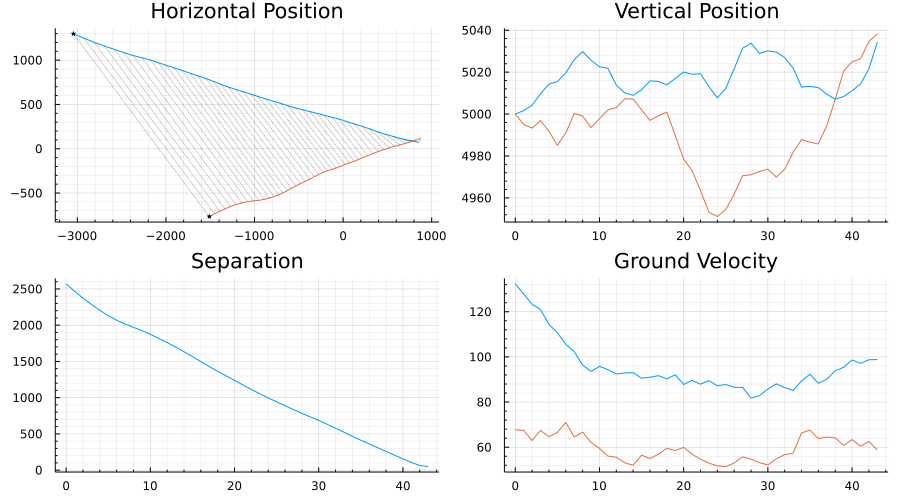

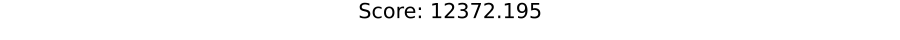

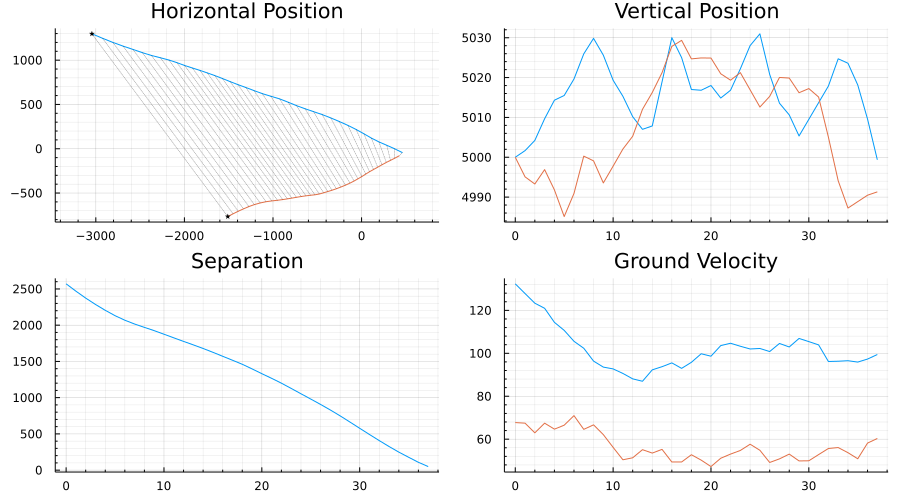

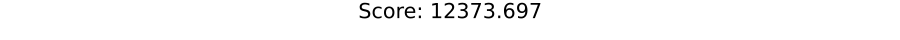

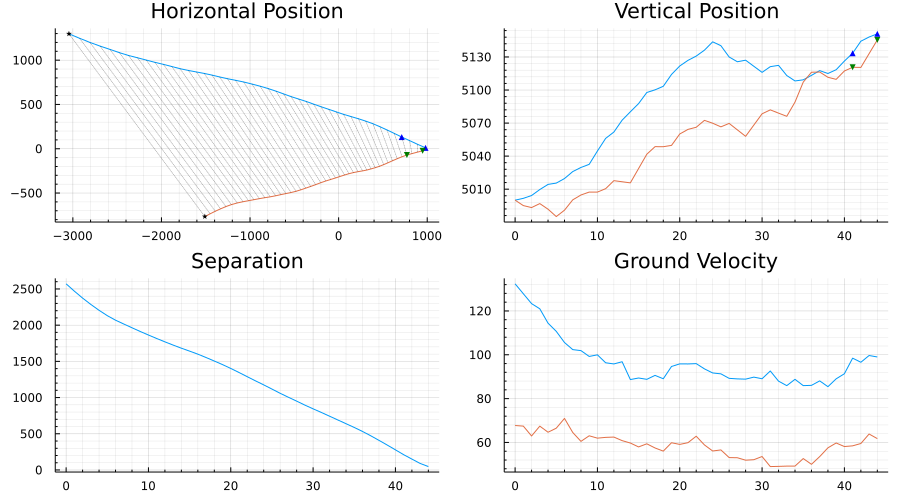

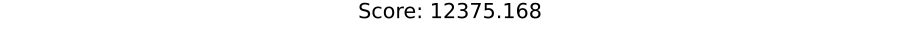

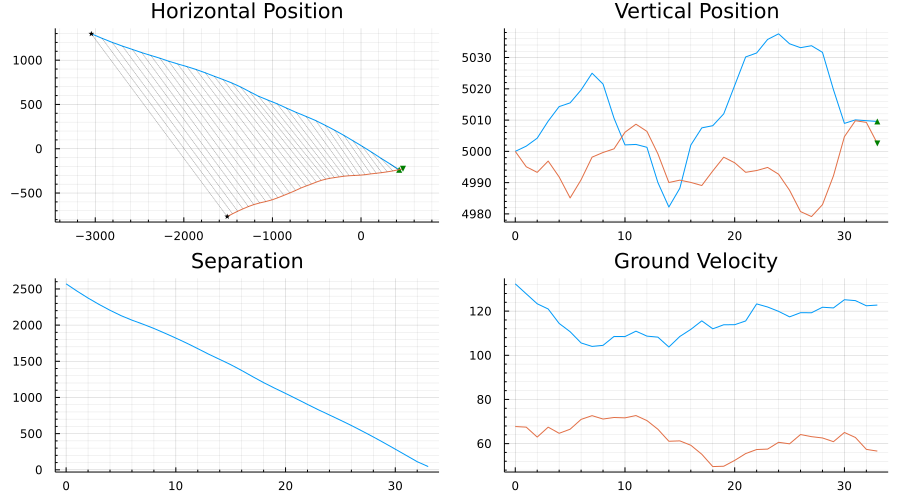

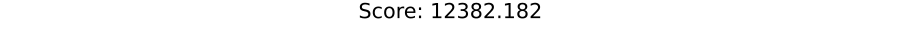

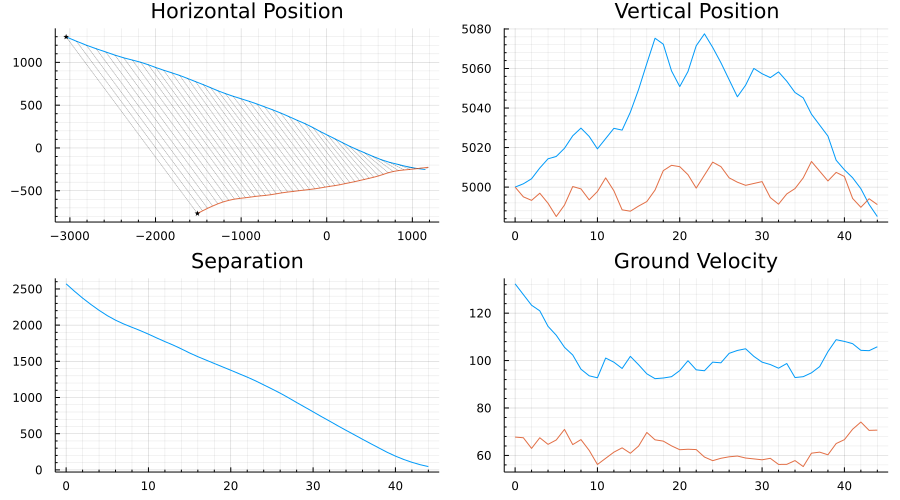

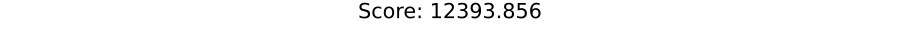

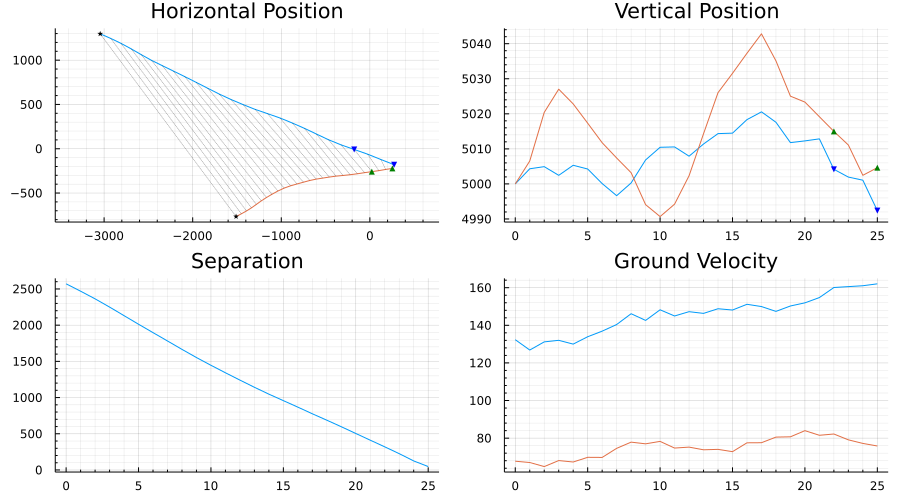

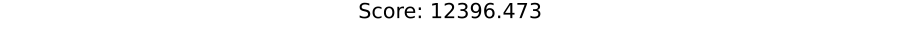

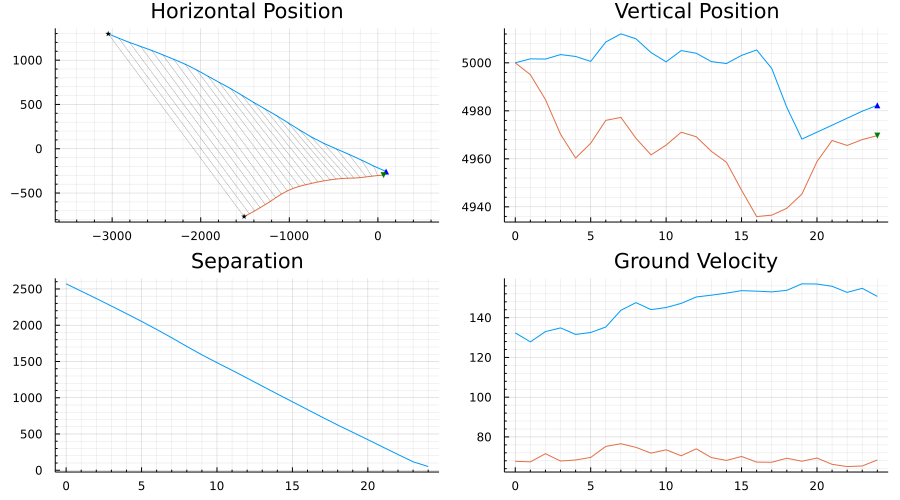

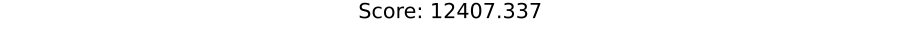

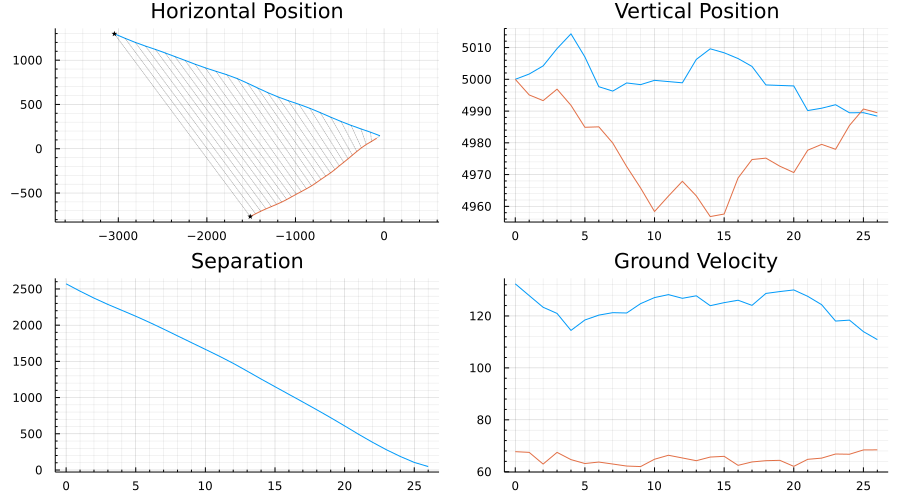

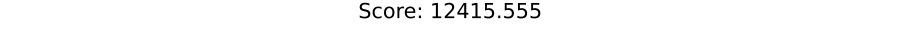

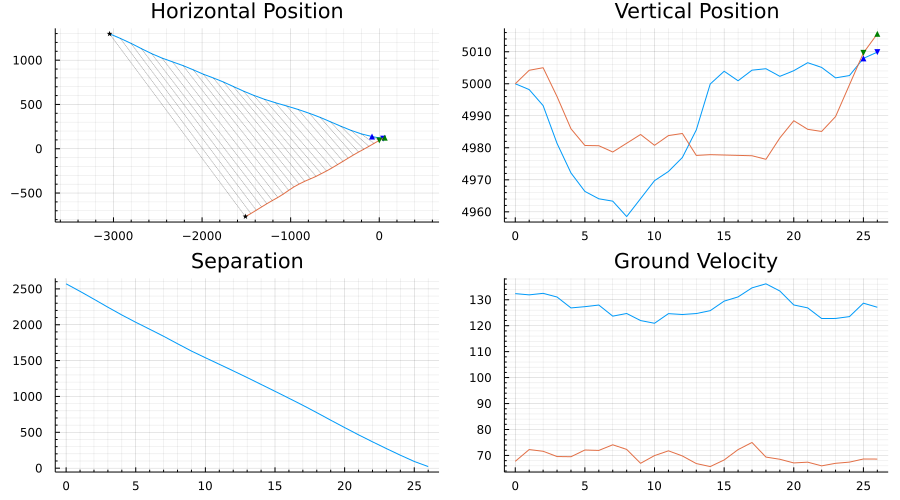

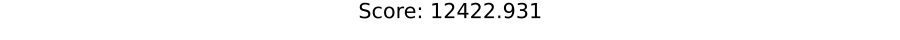

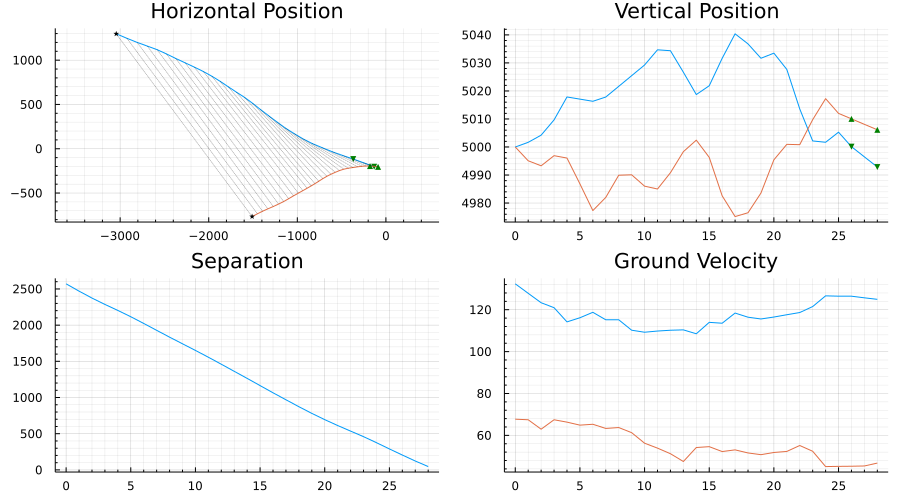

In [7]:
mdp = mdp_env(; logging=true)

for as in keys(sol)
    AdaStress.Solvers.replay!(mdp, as)
    score = round(sol[as]; digits=3)
    fmt = (framestyle=nothing, showaxis=false, xticks=false, yticks=false, size=(900,40))
    display(SimpleACAS.plot(; title="Score: $score", fmt...))
    display(SimpleACAS.visualize(mdp.sim))
end